<a href="https://colab.research.google.com/github/maitry-ml/ml-indian-equity-portfolio/blob/main/DSAI_FIN_ASSGN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
pip install yfinance

# 1. MARKET DATA

In [24]:
import yfinance as yf
import pandas as pd

tickers = ["RELIANCE.NS", "HDFCBANK.NS", "INFY.NS",
           "BHARTIARTL.NS", "HINDUNILVR.NS", "M&M.NS"]

# Download all at once
raw = yf.download(tickers, start="2020-01-01", end="2025-12-31", auto_adjust=True, group_by="ticker")

# Reshape to long format
all_data = []
for ticker in tickers:
    df = raw[ticker].copy()
    df = df.reset_index()
    df["Stock"] = ticker
    df = df[["Date", "Stock", "Open", "High", "Low", "Close", "Volume"]]
    all_data.append(df)

panel = pd.concat(all_data, ignore_index=True)
panel.columns.name = None

# ── Count missing rows BEFORE dropping ──────────────────────────────
missing_rows = panel["Close"].isna().sum()
total_rows   = len(panel)
print(f"Total rows        : {total_rows}")
print(f"Rows with no data : {missing_rows}")
print(f"Per stock breakdown:")
print(panel.groupby("Stock")["Close"].apply(lambda x: x.isna().sum()).rename("Missing Rows"))
print()

# ── Now drop ─────────────────────────────────────────────────────────
market_data = panel.dropna(subset=["Close"])

print(market_data.head(10))
print("Shape after dropping:", market_data.shape)

[*********************100%***********************]  6 of 6 completed

Total rows        : 8916
Rows with no data : 0
Per stock breakdown:
Stock
BHARTIARTL.NS    0
HDFCBANK.NS      0
HINDUNILVR.NS    0
INFY.NS          0
M&M.NS           0
RELIANCE.NS      0
Name: Missing Rows, dtype: int64

        Date        Stock        Open        High         Low       Close  \
0 2020-01-01  RELIANCE.NS  679.081936  683.152852  673.490062  675.324158   
1 2020-01-02  RELIANCE.NS  676.397899  689.348791  676.397899  686.821228   
2 2020-01-03  RELIANCE.NS  685.792252  689.661895  681.318729  687.648804   
3 2020-01-06  RELIANCE.NS  679.976657  683.510705  670.134872  671.700623   
4 2020-01-07  RELIANCE.NS  679.529321  686.463335  677.068889  682.034546   
5 2020-01-08  RELIANCE.NS  677.739963  686.440942  675.503202  676.912354   
6 2020-01-09  RELIANCE.NS  688.297445  693.397244  685.009404  692.502563   
7 2020-01-10  RELIANCE.NS  694.247173  696.953672  688.767105  692.345947   
8 2020-01-13  RELIANCE.NS  691.182919  697.289264  688.208016  690.578979   
9 2020-0

In [25]:
market_data

,Date,Stock,Open,High,Low,Close,Volume
0,2020-01-01,RELIANCE.NS,679.081936,683.152852,673.490062,675.324158,14004468
1,2020-01-02,RELIANCE.NS,676.397899,689.348791,676.397899,686.821228,17710316
2,2020-01-03,RELIANCE.NS,685.792252,689.661895,681.318729,687.648804,20984698
3,2020-01-06,RELIANCE.NS,679.976657,683.510705,670.134872,671.700623,24519177
4,2020-01-07,RELIANCE.NS,679.529321,686.463335,677.068889,682.034546,16683622
...,...,...,...,...,...,...,...
8911,2025-12-23,M&M.NS,3619.199951,3637.500000,3605.000000,3625.100098,1413628
8912,2025-12-24,M&M.NS,3624.600098,3658.000000,3612.100098,3636.699951,842897
8913,2025-12-26,M&M.NS,3636.699951,3647.000000,3614.600098,3623.100098,829910
8914,2025-12-29,M&M.NS,3622.699951,3640.199951,3588.100098,3592.100098,1034692


# 2. MACRO INDICATORS


In [26]:
# ── STEP 2: Macro Indicators  ─────────────────────────────────
import io
import requests
import yfinance as yf
import pandas as pd
import requests

START = "2019-12-31"
END   = "2025-12-31"
daily_idx = pd.date_range(START, END, freq="D")

# ── 2a. USD-INR and Crude Oil via yfinance ────────────────────────────
macro_tickers = {
    "USDINR"  : "INR=X",
    "CrudeOil": "CL=F",
}

macro_raw = yf.download(
    list(macro_tickers.values()),
    start=START, end=END,
    auto_adjust=True,
    group_by="ticker"
)

macro_frames = []
for col_name, ticker in macro_tickers.items():
    s = macro_raw[ticker]["Close"].copy()
    s.name = col_name
    macro_frames.append(s)

macro_df = pd.concat(macro_frames, axis=1)
macro_df.index = pd.to_datetime(macro_df.index)
macro_df = macro_df.reindex(daily_idx).ffill()

# ── 2b. India 10Y Bond Yield via FRED ───────
fred_url = (
    "https://fred.stlouisfed.org/graph/fredgraph.csv"
    "?id=INDIRLTLT01STM"
)
try:

    resp = requests.get(fred_url)
    in10y = pd.read_csv(io.StringIO(resp.text),
                        parse_dates=["observation_date"],
                        index_col="observation_date")
    in10y.columns = ["IN10Y"]
    in10y = in10y.replace(".", float("nan")).astype(float)
    in10y = in10y.reindex(daily_idx).ffill()
    macro_df["IN10Y"] = in10y["IN10Y"].values
    print("India 10Y loaded from FRED")
except Exception as e:
    print(f"⚠️  FRED fetch failed: {e}")

# ── 2c. CPI (monthly → daily) ─────────────────────────────────────────
cpi_data = {
    "2020-01": 7.59, "2020-02": 6.58, "2020-03": 5.84, "2020-04": 7.22,
    "2020-05": 5.84, "2020-06": 6.09, "2020-07": 6.93, "2020-08": 6.69,
    "2020-09": 7.27, "2020-10": 7.61, "2020-11": 6.93, "2020-12": 4.59,
    "2021-01": 4.06, "2021-02": 5.03, "2021-03": 5.52, "2021-04": 4.23,
    "2021-05": 6.30, "2021-06": 6.26, "2021-07": 5.59, "2021-08": 5.30,
    "2021-09": 4.35, "2021-10": 4.48, "2021-11": 4.91, "2021-12": 5.59,
    "2022-01": 6.01, "2022-02": 6.07, "2022-03": 6.95, "2022-04": 7.79,
    "2022-05": 7.04, "2022-06": 7.01, "2022-07": 6.71, "2022-08": 7.00,
    "2022-09": 7.41, "2022-10": 6.77, "2022-11": 5.88, "2022-12": 5.72,
    "2023-01": 6.52, "2023-02": 6.44, "2023-03": 5.66, "2023-04": 4.70,
    "2023-05": 4.25, "2023-06": 4.81, "2023-07": 7.44, "2023-08": 6.83,
    "2023-09": 5.02, "2023-10": 4.87, "2023-11": 5.55, "2023-12": 5.69,
    "2024-01": 5.10, "2024-02": 5.09, "2024-03": 4.85, "2024-04": 4.83,
    "2024-05": 4.75, "2024-06": 5.08, "2024-07": 3.54, "2024-08": 3.65,
    "2024-09": 5.49, "2024-10": 6.21, "2024-11": 5.48, "2024-12": 5.22,
    "2025-01": 4.26, "2025-02": 3.61, "2025-03": 3.34, "2025-04": 3.16,
    "2025-05": 2.82, "2025-06": 2.10,
}
cpi_series = pd.Series(cpi_data)
cpi_series.index = pd.to_datetime(cpi_series.index)
cpi_daily = cpi_series.reindex(daily_idx).ffill()
macro_df["CPI_YoY"] = cpi_daily.values


# ── 2d. Lagging everything by 1 day (no look-ahead bias) ──────────────────
macro_lagged = macro_df.shift(1)
macro_lagged.index.name = "Date"

macro_lagged = macro_lagged.loc["2020-01-01":]  # dropping 31st DEC

print("\nFinal macro shape:", macro_lagged.shape)


[*********************100%***********************]  2 of 2 completed


India 10Y loaded from FRED

Final macro shape: (2192, 4)


In [29]:
for name, df in [("macro_df", macro_df), ("macro_lagged", macro_lagged)]:
    print(f"{name}")
    print(df.isna().sum().to_frame("  Missing"))
    print(f"Total: {df.isna().sum().sum()} / {df.size} cells\n")

macro_df
          Missing
USDINR          0
CrudeOil        0
IN10Y           1
CPI_YoY         1
Total: 2 / 8772 cells

macro_lagged
          Missing
USDINR          0
CrudeOil        0
IN10Y           1
CPI_YoY         1
Total: 2 / 8768 cells



In [30]:
print(macro_df.head())

               USDINR   CrudeOil  IN10Y  CPI_YoY
Date                                            
2019-12-31  71.310997  61.060001    NaN      NaN
2020-01-01  71.275803  61.060001   6.82     7.59
2020-01-02  71.025002  61.180000   6.82     7.59
2020-01-03  71.415001  63.049999   6.82     7.59
2020-01-04  71.415001  63.049999   6.82     7.59


In [31]:
print(macro_lagged.head())

               USDINR   CrudeOil  IN10Y  CPI_YoY
Date                                            
2020-01-01  71.310997  61.060001    NaN      NaN
2020-01-02  71.275803  61.060001   6.82     7.59
2020-01-03  71.025002  61.180000   6.82     7.59
2020-01-04  71.415001  63.049999   6.82     7.59
2020-01-05  71.415001  63.049999   6.82     7.59


# 3. FUNDAMENTAL DATA

In [32]:
import pandas as pd
import numpy as np

def load_from_drive(file_id):
    url = f"https://drive.google.com/uc?id={file_id}"
    return pd.read_csv(url)



eps_raw    = load_from_drive("1B1KvYlMUsFyUZeDhQGza759UWh7yUjY4")
ratios_raw = load_from_drive("12yY0yP97bWWJ1FQLV1zFGaU88-7fqZg5")

print(eps_raw.head())

         Stock   Quarter    EPS
0  RELIANCE.NS  Sep 2019  18.36
1  RELIANCE.NS  Dec 2019  13.78
2  RELIANCE.NS  Mar 2020  13.42
3  RELIANCE.NS  Jun 2020  19.95
4  RELIANCE.NS  Sep 2020  14.34


In [33]:
# ── STEP 3a. Align quarterly EPS → daily ─────────────────────────────
all_eps = []

daily_idx_extended = pd.date_range("2019-09-01", "2025-12-31", freq="D")

for ticker in eps_raw["Stock"].unique():
    df = eps_raw[eps_raw["Stock"] == ticker].copy()

    df["Date"] = pd.to_datetime(df["Quarter"], format="%b %Y") \
                   + pd.offsets.MonthEnd(0) \
                   + pd.DateOffset(days=45)

    df = df.set_index("Date")[["EPS"]].sort_index()
    df = pd.to_numeric(df["EPS"], errors="coerce").to_frame()
    df = df.groupby(level=0).last()

    eps_daily = df.reindex(daily_idx_extended).ffill().bfill()
    eps_daily = eps_daily.loc["2020-01-01":"2025-12-31"]
    eps_daily["Stock"] = ticker
    all_eps.append(eps_daily)

eps_panel = pd.concat(all_eps).reset_index()
eps_panel.columns.name = None
eps_panel.rename(columns={"index": "Date"}, inplace=True)
print("✅ EPS aligned:", eps_panel.shape)
print(eps_panel.head())

✅ EPS aligned: (13152, 3)
        Date    EPS        Stock
0 2020-01-01  18.36  RELIANCE.NS
1 2020-01-02  18.36  RELIANCE.NS
2 2020-01-03  18.36  RELIANCE.NS
3 2020-01-04  18.36  RELIANCE.NS
4 2020-01-05  18.36  RELIANCE.NS


In [34]:
# ── 3b. Align annual ROE & D/E → daily ───────────────────────────────
all_ratios = []
daily_idx  = pd.date_range("2020-01-01", "2025-12-31", freq="D")

for ticker in ratios_raw["Stock"].unique():
    df = ratios_raw[ratios_raw["Stock"] == ticker].copy()
    df["Date"] = pd.to_datetime(df["Year"].astype(str) + "-03-31")
    df = df.set_index("Date")[["ROE","DebtEquity"]].sort_index()
    df = df.apply(pd.to_numeric, errors="coerce")
    df = df.groupby(level=0).last()

    ratios_daily = df.reindex(daily_idx).ffill().bfill()
    ratios_daily["Stock"] = ticker
    all_ratios.append(ratios_daily)

ratios_panel = pd.concat(all_ratios).reset_index()
ratios_panel.columns.name = None
ratios_panel.rename(columns={"index": "Date"}, inplace=True)
print("✅ ROE & D/E aligned:", ratios_panel.shape)

# ── 3c. Merge EPS + ROE + D/E ─────────────────────────────────────────
fundamentals = pd.merge(eps_panel, ratios_panel, on=["Date","Stock"], how="left")
fundamentals.columns.name = None

print("\nShape", fundamentals.shape)
print("\nSample")
print(fundamentals.head())


✅ ROE & D/E aligned: (13152, 4)

Shape (13152, 5)

Sample
        Date    EPS        Stock   ROE  DebtEquity
0 2020-01-01  18.36  RELIANCE.NS  7.01        0.32
1 2020-01-02  18.36  RELIANCE.NS  7.01        0.32
2 2020-01-03  18.36  RELIANCE.NS  7.01        0.32
3 2020-01-04  18.36  RELIANCE.NS  7.01        0.32
4 2020-01-05  18.36  RELIANCE.NS  7.01        0.32


Jan 2020 → Mar 2021 = 15 months out of 72 months total
= about 21% of the dataset has approximated ROE & D/E

# 4. SENTIMENT DATA

Real-time sentiment is demonstrated using GNews API + FinBERT. Due to historical news API limitations,Sector based Nifty return was was used as sentiment proxy for 2020-2025 backtesting period. All sentiment features were lagged by 1 trading day to prevent look-ahead bias.

In [35]:
# ── Installing required libraries ────────────────────────────────────────
!pip install transformers torch gnews -q

import pandas as pd
import numpy as np
from gnews import GNews
from transformers import pipeline
import time

print("✅ Libraries installed")

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.1/331.1 kB 17.1 MB/s eta 0:00:00
✅ Libraries installed


In [2]:
# ── Loading FinBERT model ────────────────────────────────────────────────
print("Loading FinBERT... (takes 1-2 minutes first time)")
finbert = pipeline(
    "text-classification",
    model="ProsusAI/finbert",
    return_all_scores=True
)
print("✅ FinBERT loaded")

Loading FinBERT... (takes 1-2 minutes first time)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: ProsusAI/finbert
Key                          | Status     |  | 
-----------------------------+------------+--+-
bert.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

✅ FinBERT loaded


In [3]:
# ── Stock search terms ────────────────────────────────────────────────
stock_queries = {
    "RELIANCE.NS"   : "Reliance Industries stock",
    "HDFCBANK.NS"   : "HDFC Bank stock",
    "INFY.NS"       : "Infosys stock",
    "M&M.NS"        : "Mahindra Mahindra stock",
    "BHARTIARTL.NS" : "Bharti Airtel stock",
    "HINDUNILVR.NS" : "Hindustan Unilever HUL stock"
}

In [11]:
# ──scoring function ────────────────────────────────────────────
def get_finbert_score(headlines):
    if not headlines:
        return 0.0

    scores = []
    for headline in headlines:
        try:
            result = finbert(headline[:512])
            # result = [{'label': 'positive', 'score': 0.75}]
            label = result[0]["label"]
            score = result[0]["score"]


            if label == "positive":
                net = score
            elif label == "negative":
                net = -score
            else:  # neutral
                net = 0.0

            scores.append(net)
        except Exception as e:
            print(f"  ⚠️ Skipping: {e}")
            continue

    return round(float(np.mean(scores)), 4) if scores else 0.0

In [16]:
# ── fetching news WITH dates ────────────────────────────────────
real_sentiment = []

for ticker, query in stock_queries.items():
    print(f"\nFetching news for {ticker}...")

    try:
        articles = google_news.get_news(query)

        if not articles:
            print(f"  No news found for {ticker}")
            continue

        # ── Extract headline AND date per article ─────────────────────
        dated_headlines = []
        for article in articles:
            try:
                title     = article["title"]
                pub_date  = pd.to_datetime(article["published date"]).normalize()
                dated_headlines.append((pub_date, title))
                print(f"  [{pub_date.date()}] {title[:60]}...")
            except:
                continue

        # ── Grouping headlines by date ───────────────────────────────────
        from collections import defaultdict
        date_groups = defaultdict(list)
        for pub_date, title in dated_headlines:
            date_groups[pub_date].append(title)

        # ── Scoring each date separately ────────────────────────────────
        for pub_date, headlines in date_groups.items():
            score = get_finbert_score(headlines)
            real_sentiment.append({
                "Date"      : pub_date,
                "Stock"     : ticker,
                "Sentiment" : score,
                "Headlines" : len(headlines)
            })
            print(f"  {pub_date.date()} → {len(headlines)} headlines → score: {score}")

        time.sleep(2)

    except Exception as e:
        print(f"  Error: {e}")

real_sentiment_df = pd.DataFrame(real_sentiment)
real_sentiment_df = real_sentiment_df.sort_values(["Stock","Date"])




Fetching news for RELIANCE.NS...
  [2026-02-20] Morgan Stanley Bullish On Reliance Industries After Rs 10 La...
  [2026-02-20] RIL share price has risen 1.5% in 30 days; what shareholders...
  [2026-02-20] Reliance Industries can rise 18%, says Morgan Stanley post ₹...
  [2026-02-20] Morgan Stanley bullish on Reliance Industries, flags AI cape...
  [2026-02-19] Reliance Industries Ltd Sees High-Value Trading Amid Market ...
  [2026-02-20] Stocks to BUY, SELL or HOLD Today, February 20: Reliance Ind...
  [2026-02-22] Buy or sell: Ganesh Dongre of Anand Rathi recommends three s...
  [2026-02-05] Reliance Industries Limited (NSE:RELIANCE) Stock's Been Slid...
  [2026-02-20] Tata Group stock hits 5% upper circuit after receiving an or...
  [2026-02-01] Reliance Industries share price slides in Sunday budget trad...
  2026-02-20 → 6 headlines → score: 0.3169
  2026-02-19 → 1 headlines → score: 0.7463
  2026-02-22 → 1 headlines → score: 0.0
  2026-02-05 → 1 headlines → score: -0.8225
  2026

In [15]:
real_sentiment_df = real_sentiment_df.sort_values(["Stock","Date"]).reset_index(drop=True)
print(real_sentiment_df)

         Date          Stock  Sentiment  Headlines
0  2026-02-13  BHARTIARTL.NS     0.0000          1
1  2026-02-17  BHARTIARTL.NS     0.4775          2
2  2026-02-18  BHARTIARTL.NS     0.0000          1
3  2026-02-19  BHARTIARTL.NS     0.9461          1
4  2026-02-20  BHARTIARTL.NS     0.0098          2
5  2026-02-21  BHARTIARTL.NS     0.0000          1
6  2026-02-22  BHARTIARTL.NS     0.3993          2
7  2026-01-19    HDFCBANK.NS     0.0000          1
8  2026-02-16    HDFCBANK.NS     0.7967          1
9  2026-02-19    HDFCBANK.NS    -0.9696          1
10 2026-02-20    HDFCBANK.NS    -0.4784          2
11 2026-02-21    HDFCBANK.NS    -0.2810          3
12 2026-02-22    HDFCBANK.NS     0.4616          2
13 2025-12-05  HINDUNILVR.NS    -0.8493          1
14 2026-02-12  HINDUNILVR.NS    -0.9585          3
15 2026-02-13  HINDUNILVR.NS    -0.9638          2
16 2026-02-16  HINDUNILVR.NS     0.4569          1
17 2026-02-17  HINDUNILVR.NS    -0.9160          1
18 2026-02-18  HINDUNILVR.NS   

## **Proxy sentiment for Historical Data**

 Due to historical news API limitations, Nifty50 return-based sentiment proxy is used for 2020-2025 backtesting period. All sentiment features are lagged by 1 trading day to prevent look-ahead bias.

In [17]:
# ── Stock-Specific Sentiment using Sector Indices ─────────────────────
import yfinance as yf
import pandas as pd
import numpy as np

daily_idx = pd.date_range("2020-01-01", "2025-12-31", freq="D")

# ── Sector index for each stock ───────────────────────────────────────
sector_indices = {
    "RELIANCE.NS"   : "^CNXENERGY",
    "HDFCBANK.NS"   : "^NSEBANK",
    "INFY.NS"       : "^CNXIT",
    "M&M.NS"        : "^CNXAUTO",
    "BHARTIARTL.NS" : "^CNXMEDIA",
    "HINDUNILVR.NS" : "^CNXFMCG"
}

def compute_sentiment(ticker):
    """Fetching sector index and converting returns to sentiment score."""
    try:
        data = yf.download(ticker, start="2019-12-31",
                           end="2025-12-31", auto_adjust=True)
        data.columns = data.columns.get_level_values(0)

        # Calculating returns on trading days only
        returns = data["Close"].pct_change().dropna()

        # Clipping and normalize to -1 to +1
        std     = float(returns.std())
        clipped = returns.clip(-3*std, 3*std)
        proxy   = (clipped / (3*std)).fillna(0)

        # Reindexing to calendar days and forward fill weekends/holidays
        proxy.index = pd.to_datetime(proxy.index)
        proxy = proxy.reindex(daily_idx).ffill().fillna(0)

        return proxy

    except Exception as e:
        print(f" Failed for {ticker}: {e} ")
        return None


# ── Computing sentiment per stock ───────────────────────────────────────
proxy_frames = []

for stock_ticker, sector_ticker in sector_indices.items():
    print(f"\nFetching sector index {sector_ticker} for {stock_ticker}...")

    proxy = compute_sentiment(sector_ticker)


    df = pd.DataFrame({
        "Date"      : daily_idx,
        "Stock"     : stock_ticker,
        "Sentiment" : proxy.values
    })
    proxy_frames.append(df)


sentiment_panel = pd.concat(proxy_frames, ignore_index=True)

# ── Lag by 1 day per stock ────────────────────────────────────────────
sentiment_panel = sentiment_panel.sort_values(["Stock","Date"])
sentiment_panel["Sentiment"] = sentiment_panel.groupby("Stock")["Sentiment"].shift(1)
sentiment_panel = sentiment_panel.dropna(subset=["Sentiment"])
sentiment_panel["Date"] = pd.to_datetime(sentiment_panel["Date"])
sentiment_panel = sentiment_panel.reset_index(drop=True)







Fetching sector index ^CNXENERGY for RELIANCE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Fetching sector index ^NSEBANK for HDFCBANK.NS...

Fetching sector index ^CNXIT for INFY.NS...

Fetching sector index ^CNXAUTO for M&M.NS...

Fetching sector index ^CNXMEDIA for BHARTIARTL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Fetching sector index ^CNXFMCG for HINDUNILVR.NS...


In [20]:
# ── Verify different scores per stock ────────────────────────────────
print("\nSector-Specific Sentiment")
print("\nShape:", sentiment_panel.shape)
print("\nSame date different stocks should have DIFFERENT values:")
print(sentiment_panel[sentiment_panel["Date"] == "2020-01-03"][["Date","Stock","Sentiment"]])
print("\nSentiment range:")
print(sentiment_panel.groupby("Stock")["Sentiment"].describe())


Sector-Specific Sentiment

Shape: (13146, 3)

Same date different stocks should have DIFFERENT values:
            Date          Stock  Sentiment
1     2020-01-03  BHARTIARTL.NS   0.064079
2192  2020-01-03    HDFCBANK.NS   0.233444
4383  2020-01-03  HINDUNILVR.NS   0.154709
6574  2020-01-03        INFY.NS  -0.018055
8765  2020-01-03         M&M.NS   0.160001
10956 2020-01-03    RELIANCE.NS   0.205163

Sentiment range:
                count      mean       std  min       25%       50%       75%  \
Stock                                                                          
BHARTIARTL.NS  2191.0 -0.002509  0.304411 -1.0 -0.169691  0.006025  0.174269   
HDFCBANK.NS    2191.0  0.013720  0.292966 -1.0 -0.132715  0.016534  0.151730   
HINDUNILVR.NS  2191.0  0.018308  0.292248 -1.0 -0.153641  0.018186  0.185671   
INFY.NS        2191.0  0.010003  0.316182 -1.0 -0.164793  0.005284  0.175955   
M&M.NS         2191.0  0.022766  0.304207 -1.0 -0.134233  0.023382  0.190333   
RELIANCE.NS    21

In [21]:
sentiment_csv = sentiment_panel[["Date", "Stock", "Sentiment"]].copy()
sentiment_csv = sentiment_csv.sort_values(["Stock", "Date"]).reset_index(drop=True)

print("=== Sentiment CSV Sample ===")
print(sentiment_csv.head(10))
print("\nShape:", sentiment_csv.shape)

# Save to CSV
sentiment_csv.to_csv("sentiment_scores.csv", index=False)
print("✅ Saved as sentiment_scores.csv")

=== Sentiment CSV Sample ===
        Date          Stock  Sentiment
0 2020-01-02  BHARTIARTL.NS  -0.092899
1 2020-01-03  BHARTIARTL.NS   0.064079
2 2020-01-04  BHARTIARTL.NS  -0.397445
3 2020-01-05  BHARTIARTL.NS  -0.397445
4 2020-01-06  BHARTIARTL.NS  -0.397445
5 2020-01-07  BHARTIARTL.NS  -0.436884
6 2020-01-08  BHARTIARTL.NS   0.184750
7 2020-01-09  BHARTIARTL.NS  -0.087832
8 2020-01-10  BHARTIARTL.NS   0.426879
9 2020-01-11  BHARTIARTL.NS   0.027222

Shape: (13146, 3)
✅ Saved as sentiment_scores.csv


In [22]:
from google.colab import files
files.download("sentiment_scores.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 5. Feature Engineering

In [36]:
# ── STEP 5: Feature Engineering ───────────────────────────────────────
!pip install ta -q

import pandas as pd
import numpy as np
import ta
from sklearn.preprocessing import RobustScaler

# ── 5a. Start with market OHLCV panel ────────────────────────────────
# 'market_data' is  OHLCV dataframe from Step 1
# Make sure it has: Date, Stock, Open, High, Low, Close, Volume
print("Market panel shape:", market_data.shape)
print(panel.head())

  Preparing metadata (setup.py) ... done
Market panel shape: (8916, 7)
        Date        Stock        Open        High         Low       Close  \
0 2020-01-01  RELIANCE.NS  679.081936  683.152852  673.490062  675.324158   
1 2020-01-02  RELIANCE.NS  676.397899  689.348791  676.397899  686.821228   
2 2020-01-03  RELIANCE.NS  685.792252  689.661895  681.318729  687.648804   
3 2020-01-06  RELIANCE.NS  679.976657  683.510705  670.134872  671.700623   
4 2020-01-07  RELIANCE.NS  679.529321  686.463335  677.068889  682.034546   

     Volume  
0  14004468  
1  17710316  
2  20984698  
3  24519177  
4  16683622  


In [38]:
# ── STEP 5b: Essential Features Only ─────────────────────────────────
feature_frames = []

for ticker in market_data["Stock"].unique():
    print(f"Processing {ticker}...")
    df = market_data[market_data["Stock"] == ticker].copy()
    df = df.sort_values("Date").reset_index(drop=True)

    # ── Log Return ────────────────────────────────────────────────────
    df["LogReturn"]   = np.log(df["Close"] / df["Close"].shift(1))

    # ── Lagged Return ─────────────────────────────────────────────────
    df["Return_lag1"] = df["LogReturn"].shift(1)

    # ── RSI ───────────────────────────────────────────────────────────
    df["RSI14"]       = ta.momentum.RSIIndicator(
                            close=df["Close"], window=14).rsi()

    # ── Price to SMA20 ratio ──────────────────────────────────────────
    df["SMA20"]             = df["Close"].rolling(20).mean()
    df["Price_SMA20_ratio"] = df["Close"] / df["SMA20"]

    # ── Volatility ────────────────────────────────────────────────────
    df["Volatility20"] = df["LogReturn"].rolling(20).std()

    # ── Volume change ────────────────────────────────────────────────
    df["LogVolume"] = np.log(df["Volume"].replace(0, np.nan) / df["Volume"].replace(0, np.nan).shift(1)
)

    # ── Target: next day log return ───────────────────────────────────
    df["Target"]       = df["LogReturn"].shift(-1)

    # Drop SMA20 raw
    df = df.drop(columns=["SMA20"])

    feature_frames.append(df)

features = pd.concat(feature_frames, ignore_index=True)
print("\n✅ Technical features shape:", features.shape)
print(features.columns.tolist())

Processing RELIANCE.NS...
Processing HDFCBANK.NS...
Processing INFY.NS...
Processing BHARTIARTL.NS...
Processing HINDUNILVR.NS...
Processing M&M.NS...

✅ Technical features shape: (8916, 14)
['Date', 'Stock', 'Open', 'High', 'Low', 'Close', 'Volume', 'LogReturn', 'Return_lag1', 'RSI14', 'Price_SMA20_ratio', 'Volatility20', 'LogVolume', 'Target']


# MERGING

In [42]:
# ── 5c. Merge all data sources ────────────────────────────────────────
features["Date"]        = pd.to_datetime(features["Date"])
macro_lagged.index      = pd.to_datetime(macro_lagged.index)
fundamentals["Date"]    = pd.to_datetime(fundamentals["Date"])
sentiment_panel["Date"] = pd.to_datetime(sentiment_panel["Date"])

# Reset macro index to merge on Date
macro_reset = macro_lagged.reset_index()

# ── Merge step by step ────────────────────────────────────────────────
master = features.copy()

# Merge macro (on Date only — same for all stocks)
master = pd.merge(master, macro_reset,
                  on="Date", how="left")

# Merge fundamentals (on Date + Stock)
master = pd.merge(master, fundamentals[["Date","Stock","EPS","ROE","DebtEquity"]],
                  on=["Date","Stock"], how="left")

# Merge sentiment (on Date + Stock)
master = pd.merge(master, sentiment_panel[["Date","Stock","Sentiment"]],
                  on=["Date","Stock"], how="left")

# ── Calculate P/E ratio ───────────────────────────────────────────────
master["PE_ratio"] = master["Close"] / master["EPS"]
master["PE_ratio"] = master["PE_ratio"].where(master["EPS"] > 0, other=np.nan)

print("=== Master Panel ===")
print("Shape:", master.shape)
print("\nColumns:", master.columns.tolist())
print("\nMissing values:")
print(master.isna().sum())


=== Master Panel ===
Shape: (8916, 23)

Columns: ['Date', 'Stock', 'Open', 'High', 'Low', 'Close', 'Volume', 'LogReturn', 'Return_lag1', 'RSI14', 'Price_SMA20_ratio', 'Volatility20', 'LogVolume', 'Target', 'USDINR', 'CrudeOil', 'IN10Y', 'CPI_YoY', 'EPS', 'ROE', 'DebtEquity', 'Sentiment', 'PE_ratio']

Missing values:
Date                   0
Stock                  0
Open                   0
High                   0
Low                    0
Close                  0
Volume                 0
LogReturn              6
Return_lag1           12
RSI14                 78
Price_SMA20_ratio    114
Volatility20         120
LogVolume             20
Target                 6
USDINR                 0
CrudeOil               0
IN10Y                  6
CPI_YoY                6
EPS                    0
ROE                    0
DebtEquity             0
Sentiment              6
PE_ratio             471
dtype: int64


In [41]:
master.head()

,Date,Stock,Open,High,Low,Close,Volume,LogReturn,Return_lag1,RSI14,...,Target,USDINR,CrudeOil,IN10Y,CPI_YoY,EPS,ROE,DebtEquity,Sentiment,PE_ratio
0,2020-01-01,RELIANCE.NS,679.081936,683.152852,673.490062,675.324158,14004468,NaN,NaN,NaN,...,0.016881,71.310997,61.060001,NaN,NaN,18.36,7.01,0.32,NaN,36.782362
1,2020-01-02,RELIANCE.NS,676.397899,689.348791,676.397899,686.821228,17710316,0.016881,NaN,NaN,...,0.001204,71.275803,61.060001,6.82,7.59,18.36,7.01,0.32,0.116649,37.408564
2,2020-01-03,RELIANCE.NS,685.792252,689.661895,681.318729,687.648804,20984698,0.001204,0.016881,NaN,...,-0.023466,71.025002,61.180000,6.82,7.59,18.36,7.01,0.32,0.205163,37.453639
3,2020-01-06,RELIANCE.NS,679.976657,683.510705,670.134872,671.700623,24519177,-0.023466,0.001204,NaN,...,0.015268,71.415001,63.049999,6.82,7.59,18.36,7.01,0.32,-0.106529,36.585001
4,2020-01-07,RELIANCE.NS,679.529321,686.463335,677.068889,682.034546,16683622,0.015268,-0.023466,NaN,...,-0.007539,71.731003,63.270000,6.82,7.59,18.36,7.01,0.32,-0.461395,37.147851


In [43]:
# ── 5d. Handle Missing Values ─────────────────────────────────────────

# PE_ratio: NaN when EPS negative → forward fill per stock
master["PE_ratio"] = master.groupby("Stock")["PE_ratio"].ffill().bfill()

# Drop rows where technical indicators are NaN
# (first ~20 rows per stock due to rolling windows)
master = master.dropna(subset=["LogReturn","RSI14","Volatility20",
                                "Price_SMA20_ratio","Target"])

print("Shape after cleaning:", master.shape)
print("\nMissing values:")
print(master.isna().sum())

Shape after cleaning: (8790, 23)

Missing values:
Date                  0
Stock                 0
Open                  0
High                  0
Low                   0
Close                 0
Volume                0
LogReturn             0
Return_lag1           0
RSI14                 0
Price_SMA20_ratio     0
Volatility20          0
LogVolume            14
Target                0
USDINR                0
CrudeOil              0
IN10Y                 0
CPI_YoY               0
EPS                   0
ROE                   0
DebtEquity            0
Sentiment             0
PE_ratio              0
dtype: int64


In [44]:
# ── Find days with zero or missing volume ─────────────────────────────
zero_vol = master[master["LogVolume"].isna()][["Date","Stock","Volume","LogVolume"]]
print("Days with missing LogVolume:")
print(zero_vol[["Date","Stock","Volume"]])

Days with missing LogVolume:
           Date          Stock    Volume
1291 2025-03-18    RELIANCE.NS         0
1292 2025-03-19    RELIANCE.NS  16162399
2777 2025-03-18    HDFCBANK.NS         0
2778 2025-03-19    HDFCBANK.NS  15221406
4263 2025-03-18        INFY.NS         0
4264 2025-03-19        INFY.NS   7387068
5749 2025-03-18  BHARTIARTL.NS         0
5750 2025-03-19  BHARTIARTL.NS   6283464
7235 2025-03-18  HINDUNILVR.NS         0
7236 2025-03-19  HINDUNILVR.NS   1341405
8721 2025-03-18         M&M.NS         0
8722 2025-03-19         M&M.NS   2438912
8838 2025-09-08         M&M.NS         0
8839 2025-09-09         M&M.NS   2879258


In [45]:
# Forward fill LogVolume for holiday/zero volume days
master["LogVolume"] = master.groupby("Stock")["LogVolume"].ffill().bfill()

# Verify
print("Missing values after fix:")
print(master[["LogVolume"]].isna().sum())
print("\nFinal master shape:", master.shape)

Missing values after fix:
LogVolume    0
dtype: int64

Final master shape: (8790, 23)


In [48]:
# ── 5e. Robust Scaling ────────────────────────────────────────────────
from sklearn.preprocessing import RobustScaler

# Columns to scale — exclude identifiers and target
cols_to_scale = ["LogReturn","Return_lag1","RSI14","Price_SMA20_ratio",
                 "Volatility20","LogVolume","USDINR","CrudeOil",
                 "IN10Y","CPI_YoY","EPS","ROE","DebtEquity",
                 "Sentiment","PE_ratio"]

# ── 5f. Train / Test Split BEFORE scaling (no look-ahead bias) ────────
train = master[master["Date"] <  "2025-10-01"].copy()
test  = master[master["Date"] >= "2025-10-01"].copy()

print(f"Train: {train.shape} — {train['Date'].min().date()} to {train['Date'].max().date()}")
print(f"Test:  {test.shape}  — {test['Date'].min().date()} to {test['Date'].max().date()}")

# ── Fit scaler on TRAIN only, transform both ──────────────────────────
scaler = RobustScaler()
train[cols_to_scale] = scaler.fit_transform(train[cols_to_scale])
test[cols_to_scale]  = scaler.transform(test[cols_to_scale])

print("\n✅ Scaling done")

train[cols_to_scale].head()

Train: (8430, 23) — 2020-01-29 to 2025-09-30
Test:  (360, 23)  — 2025-10-01 to 2025-12-29

✅ Scaling done


,LogReturn,Return_lag1,RSI14,Price_SMA20_ratio,Volatility20,LogVolume,USDINR,CrudeOil,IN10Y,CPI_YoY,EPS,ROE,DebtEquity,Sentiment,PE_ratio
20,0.296636,-1.384281,-0.863771,-0.748416,0.112326,0.031109,-1.188483,-1.099592,0.044944,1.025126,0.372331,-0.644041,-0.2325,-0.621659,-0.316645
21,-1.462422,0.296909,-1.263457,-1.179707,0.148295,-0.150406,-1.212725,-1.108328,0.044944,1.025126,0.372331,-0.644041,-0.2325,0.350218,-0.321426
22,-1.333512,-1.461569,-1.530002,-1.537348,0.222550,0.752961,-1.204675,-1.177635,0.044944,1.025126,0.372331,-0.644041,-0.2325,-0.990672,-0.325676
23,-1.112836,-1.332702,-1.706164,-1.822224,0.186579,-0.190699,-1.165352,-1.211415,-0.134831,0.517588,0.372331,-0.644041,-0.2325,-1.916173,-0.329139
24,1.672164,-1.112099,-0.986587,-1.196747,0.341340,-0.303130,-1.181949,-1.295865,-0.134831,0.517588,0.372331,-0.644041,-0.2325,-1.651505,-0.323723


#  6.MODEL TRAINING + VALIDATION

In [49]:
# ── STEP 6: ML Model + Walk-Forward Validation ────────────────────────
!pip install lightgbm -q

import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.feature_selection import RFE
from sklearn.linear_model import Ridge
import warnings
warnings.filterwarnings("ignore")

# ── Feature and target columns ────────────────────────────────────────
feature_cols = ["LogReturn","Return_lag1","RSI14","Price_SMA20_ratio",
                "Volatility20","LogVolume","USDINR","CrudeOil",
                "IN10Y","CPI_YoY","EPS","ROE","DebtEquity",
                "Sentiment","PE_ratio"]

target_col = "Target"

# ── 6a. Define Walk-Forward Folds ─────────────────────────────────────
train["Date"] = pd.to_datetime(train["Date"])

# Generate 6-month validation folds with minimum 12 months training
folds      = []
val_start  = pd.Timestamp("2021-01-01")  # start after 12 months training
fold_end   = pd.Timestamp("2025-09-30")

while val_start + pd.DateOffset(months=6) <= fold_end:
    val_end = val_start + pd.DateOffset(months=6)
    folds.append({
        "train_end"  : val_start,
        "val_start"  : val_start,
        "val_end"    : val_end
    })
    val_start = val_end

print(f"Total folds: {len(folds)}")
for i, f in enumerate(folds):
    print(f"Fold {i+1}: Train → {f['train_end'].date()} | "
          f"Val {f['val_start'].date()} → {f['val_end'].date()}")

Total folds: 9
Fold 1: Train → 2021-01-01 | Val 2021-01-01 → 2021-07-01
Fold 2: Train → 2021-07-01 | Val 2021-07-01 → 2022-01-01
Fold 3: Train → 2022-01-01 | Val 2022-01-01 → 2022-07-01
Fold 4: Train → 2022-07-01 | Val 2022-07-01 → 2023-01-01
Fold 5: Train → 2023-01-01 | Val 2023-01-01 → 2023-07-01
Fold 6: Train → 2023-07-01 | Val 2023-07-01 → 2024-01-01
Fold 7: Train → 2024-01-01 | Val 2024-01-01 → 2024-07-01
Fold 8: Train → 2024-07-01 | Val 2024-07-01 → 2025-01-01
Fold 9: Train → 2025-01-01 | Val 2025-01-01 → 2025-07-01


In [50]:
# ── 6b. RFE Feature Selection ─────────────────────────────────────────
print("\nRunning RFE to select best features...")

# Use Ridge regression for RFE (fast and stable)
X_rfe = train[feature_cols].values
y_rfe = train[target_col].values

ridge   = Ridge(alpha=1.0)
rfe     = RFE(estimator=ridge, n_features_to_select=10, step=1)
rfe.fit(X_rfe, y_rfe)

selected_features = [f for f, s in zip(feature_cols, rfe.support_) if s]
dropped_features  = [f for f, s in zip(feature_cols, rfe.support_) if not s]

print(f"\n✅ Selected features ({len(selected_features)}):")
print(selected_features)
print(f"\n❌ Dropped features ({len(dropped_features)}):")
print(dropped_features)



Running RFE to select best features...

✅ Selected features (10):
['LogReturn', 'Return_lag1', 'RSI14', 'Price_SMA20_ratio', 'Volatility20', 'USDINR', 'CrudeOil', 'IN10Y', 'CPI_YoY', 'Sentiment']

❌ Dropped features (5):
['LogVolume', 'EPS', 'ROE', 'DebtEquity', 'PE_ratio']


In [52]:
# ── 6c. Walk-Forward Training Loop ───────────────────────────────────
fold_results = []

lgb_params = {
    "objective"        : "regression",
    "metric"           : "rmse",
    "learning_rate"    : 0.05,
    "num_leaves"       : 31,
    "min_child_samples": 20,
    "feature_fraction" : 0.8,
    "bagging_fraction" : 0.8,
    "bagging_freq"     : 5,
    "reg_alpha"        : 0.1,   # L1 regularization
    "reg_lambda"       : 0.1,   # L2 regularization
    "verbose"          : -1
}

for i, fold in enumerate(folds):
    # ── Split data ────────────────────────────────────────────────────
    fold_train = train[train["Date"] <  fold["train_end"]]
    fold_val   = train[(train["Date"] >= fold["val_start"]) &
                       (train["Date"] <  fold["val_end"])]

    if len(fold_train) < 100 or len(fold_val) < 10:
        continue

    X_train = fold_train[selected_features].values
    y_train = fold_train[target_col].values
    X_val   = fold_val[selected_features].values
    y_val   = fold_val[target_col].values

    # ── Train LightGBM ────────────────────────────────────────────────
    dtrain = lgb.Dataset(X_train, label=y_train)
    dval   = lgb.Dataset(X_val,   label=y_val, reference=dtrain)

    model = lgb.train(
        lgb_params,
        dtrain,
        num_boost_round      = 500,
        valid_sets           = [dval],
        callbacks            = [lgb.early_stopping(50, verbose=False),
                                 lgb.log_evaluation(period=-1)]
    )

    # ── Predict and evaluate ──────────────────────────────────────────
    y_pred = model.predict(X_val)

    rmse    = np.sqrt(mean_squared_error(y_val, y_pred))
    mae     = mean_absolute_error(y_val, y_pred)
    dir_acc = np.mean(np.sign(y_pred) == np.sign(y_val)) * 100

    # ── Per stock directional accuracy ────────────────────────────────
    fold_val         = fold_val.copy()
    fold_val["Pred"] = y_pred
    per_stock_acc    = fold_val.groupby("Stock").apply(
        lambda x: np.mean(np.sign(x["Pred"]) == np.sign(x["Target"])) * 100
    ).round(2)

    fold_results.append({
        "Fold"      : i + 1,
        "Val_Start" : fold["val_start"].date(),
        "Val_End"   : fold["val_end"].date(),
        "RMSE"      : round(rmse, 6),
        "MAE"       : round(mae, 6),
        "DirAcc"    : round(dir_acc, 2),
        "PerStock"  : per_stock_acc
    })

    print(f"Fold {i+1} | {fold['val_start'].date()} → {fold['val_end'].date()} | "
          f"RMSE={rmse:.6f} | MAE={mae:.6f} | DirAcc={dir_acc:.2f}%")

Fold 1 | 2021-01-01 → 2021-07-01 | RMSE=0.017240 | MAE=0.012697 | DirAcc=53.28%
Fold 2 | 2021-07-01 → 2022-01-01 | RMSE=0.014391 | MAE=0.010670 | DirAcc=52.25%
Fold 3 | 2022-01-01 → 2022-07-01 | RMSE=0.018663 | MAE=0.014304 | DirAcc=50.81%
Fold 4 | 2022-07-01 → 2023-01-01 | RMSE=0.013878 | MAE=0.010405 | DirAcc=53.60%
Fold 5 | 2023-01-01 → 2023-07-01 | RMSE=0.012294 | MAE=0.008973 | DirAcc=51.23%
Fold 6 | 2023-07-01 → 2024-01-01 | RMSE=0.011729 | MAE=0.008362 | DirAcc=52.57%
Fold 7 | 2024-01-01 → 2024-07-01 | RMSE=0.016338 | MAE=0.011329 | DirAcc=52.36%
Fold 8 | 2024-07-01 → 2025-01-01 | RMSE=0.014224 | MAE=0.010393 | DirAcc=52.78%
Fold 9 | 2025-01-01 → 2025-07-01 | RMSE=0.015091 | MAE=0.011109 | DirAcc=52.98%


In [53]:
# ── 6d. Summary of Walk-Forward Results ──────────────────────────────
results_df = pd.DataFrame([{
    "Fold"      : r["Fold"],
    "Val_Start" : r["Val_Start"],
    "Val_End"   : r["Val_End"],
    "RMSE"      : r["RMSE"],
    "MAE"       : r["MAE"],
    "DirAcc"    : r["DirAcc"]
} for r in fold_results])

print("\n=== Walk-Forward Validation Results ===")
print(results_df.to_string(index=False))
print(f"\nAverage RMSE : {results_df['RMSE'].mean():.6f}")
print(f"Average MAE  : {results_df['MAE'].mean():.6f}")
print(f"Average DirAcc: {results_df['DirAcc'].mean():.2f}%")

# ── Per stock average directional accuracy ────────────────────────────
print("\n=== Per Stock Directional Accuracy (avg across folds) ===")
all_stock_acc = pd.concat([r["PerStock"] for r in fold_results], axis=1)
all_stock_acc.columns = [f"Fold{r['Fold']}" for r in fold_results]
all_stock_acc["Average"] = all_stock_acc.mean(axis=1).round(2)
print(all_stock_acc)


=== Walk-Forward Validation Results ===
 Fold  Val_Start    Val_End     RMSE      MAE  DirAcc
    1 2021-01-01 2021-07-01 0.017240 0.012697   53.28
    2 2021-07-01 2022-01-01 0.014391 0.010670   52.25
    3 2022-01-01 2022-07-01 0.018663 0.014304   50.81
    4 2022-07-01 2023-01-01 0.013878 0.010405   53.60
    5 2023-01-01 2023-07-01 0.012294 0.008973   51.23
    6 2023-07-01 2024-01-01 0.011729 0.008362   52.57
    7 2024-01-01 2024-07-01 0.016338 0.011329   52.36
    8 2024-07-01 2025-01-01 0.014224 0.010393   52.78
    9 2025-01-01 2025-07-01 0.015091 0.011109   52.98

Average RMSE : 0.014872
Average MAE  : 0.010916
Average DirAcc: 52.43%

=== Per Stock Directional Accuracy (avg across folds) ===
               Fold1  Fold2  Fold3  Fold4  Fold5  Fold6  Fold7  Fold8  Fold9  \
Stock                                                                          
BHARTIARTL.NS  62.30  48.41  48.78   56.8  50.82  49.59  55.00  51.59  57.72   
HDFCBANK.NS    52.46  51.59  52.03   52.8  57.38

In [54]:
# ── 6e. Train Final Model on Full Training Data ───────────────────────
print("\nTraining final model on full training data...")

X_train_full = train[selected_features].values
y_train_full = train[target_col].values

dtrain_full = lgb.Dataset(X_train_full, label=y_train_full)

final_model = lgb.train(
    lgb_params,
    dtrain_full,
    num_boost_round = 500,
    callbacks       = [lgb.log_evaluation(period=-1)]
)

# ── Predict on test set (Oct-Dec 2025) ────────────────────────────────
X_test  = test[selected_features].values
y_test  = test[target_col].values
y_test_pred = final_model.predict(X_test)

test = test.copy()
test["Predicted_Return"] = y_test_pred

# ── Test set metrics ──────────────────────────────────────────────────
test_rmse    = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae     = mean_absolute_error(y_test, y_test_pred)
test_dir_acc = np.mean(np.sign(y_test_pred) == np.sign(y_test)) * 100

print("\n=== Final Test Set Results (Oct-Dec 2025) ===")
print(f"RMSE            : {test_rmse:.6f}")
print(f"MAE             : {test_mae:.6f}")
print(f"Directional Acc : {test_dir_acc:.2f}%")

print("\n=== Per Stock Test Accuracy ===")
test_stock_acc = test.groupby("Stock").apply(
    lambda x: np.mean(np.sign(x["Predicted_Return"]) == np.sign(x["Target"])) * 100
).round(2)
print(test_stock_acc)


Training final model on full training data...

=== Final Test Set Results (Oct-Dec 2025) ===
RMSE            : 0.010923
MAE             : 0.008333
Directional Acc : 51.39%

=== Per Stock Test Accuracy ===
Stock
BHARTIARTL.NS    60.00
HDFCBANK.NS      51.67
HINDUNILVR.NS    36.67
INFY.NS          51.67
M&M.NS           55.00
RELIANCE.NS      53.33
dtype: float64


# STEP 7. PORTFOLIO

In [78]:
# ── STEP 7: Complete Portfolio Construction ───────────────────────────
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import yfinance as yf

# ── 7a. Pivot to wide format ──────────────────────────────────────────
pred_wide   = test.pivot(index="Date", columns="Stock",
                          values="Predicted_Return")
actual_wide = test.pivot(index="Date", columns="Stock",
                          values="Target")

stocks_in_test = actual_wide.columns.tolist()
print("Stocks in portfolio:", stocks_in_test)
print("Trading days:", len(pred_wide))

# ── 7b. Dynamic weights from predicted returns ────────────────────────
pred_clipped  = pred_wide.clip(lower=0)
daily_weights = pred_clipped.div(
    pred_clipped.sum(axis=1).replace(0, np.nan), axis=0
).fillna(1/6)

print("\n=== Sample Daily Weights ===")
print(daily_weights.head(5).round(4))
print("\nWeight sum per day (should all be 1.0):")
print(daily_weights.sum(axis=1).head(5).round(4))





Stocks in portfolio: ['BHARTIARTL.NS', 'HDFCBANK.NS', 'HINDUNILVR.NS', 'INFY.NS', 'M&M.NS', 'RELIANCE.NS']
Trading days: 60

=== Sample Daily Weights ===
Stock       BHARTIARTL.NS  HDFCBANK.NS  HINDUNILVR.NS  INFY.NS  M&M.NS  \
Date                                                                     
2025-10-01         0.1850       0.1397         0.0000   0.3333  0.1610   
2025-10-03         0.1865       0.1689         0.0869   0.2274  0.1464   
2025-10-06         0.0413       0.0681         0.2858   0.0341  0.4948   
2025-10-07         0.0000       0.0928         0.1431   0.4168  0.3150   
2025-10-08         0.0054       0.2897         0.2141   0.0000  0.1480   

Stock       RELIANCE.NS  
Date                     
2025-10-01       0.1810  
2025-10-03       0.1839  
2025-10-06       0.0759  
2025-10-07       0.0322  
2025-10-08       0.3428  

Weight sum per day (should all be 1.0):
Date
2025-10-01    1.0
2025-10-03    1.0
2025-10-06    1.0
2025-10-07    1.0
2025-10-08    1.0
dtype: fl

In [79]:
# ── 7c. Portfolio returns ─────────────────────────────────────────────
portfolio_returns = (actual_wide * daily_weights).sum(axis=1)

print("\n=== Portfolio Daily Returns ===")
print(portfolio_returns.head(10))
print(f"\nMean daily return : {portfolio_returns.mean():.6f}")
print(f"Std daily return  : {portfolio_returns.std():.6f}")

# ── 7d. Performance metrics ───────────────────────────────────────────
trading_days   = 252
risk_free_rate = 0.065 / trading_days

# Sharpe Ratio
sharpe = ((portfolio_returns.mean() - risk_free_rate) /
           portfolio_returns.std()) * np.sqrt(trading_days)

# Equity curve
cum_returns = (1 + portfolio_returns).cumprod()

# Maximum Drawdown
rolling_max = cum_returns.cummax()
drawdown    = (cum_returns - rolling_max) / rolling_max
mdd         = drawdown.min()

# Hit Ratio
hit_ratio = (portfolio_returns > 0).mean() * 100

# Annualized metrics
ann_return = portfolio_returns.mean() * trading_days * 100
ann_vol    = portfolio_returns.std() * np.sqrt(trading_days) * 100

print("\n=== Portfolio Performance Metrics ===")
print(f"Annualized Return     : {ann_return:.2f}%")
print(f"Annualized Volatility : {ann_vol:.2f}%")
print(f"Sharpe Ratio          : {sharpe:.4f}")
print(f"Maximum Drawdown      : {mdd*100:.2f}%")
print(f"Hit Ratio             : {hit_ratio:.2f}%")


=== Portfolio Daily Returns ===
Date
2025-10-01    0.002262
2025-10-03    0.008523
2025-10-06    0.001498
2025-10-07    0.002524
2025-10-08    0.004319
2025-10-09    0.003443
2025-10-10   -0.004518
2025-10-13    0.000592
2025-10-14    0.002052
2025-10-15    0.007779
dtype: float64

Mean daily return : 0.001643
Std daily return  : 0.006256

=== Portfolio Performance Metrics ===
Annualized Return     : 41.40%
Annualized Volatility : 9.93%
Sharpe Ratio          : 3.5144
Maximum Drawdown      : -2.03%
Hit Ratio             : 60.00%


In [89]:
# ── Accuracy-Based Weights (HUL = 0) ─────────────────────────────────
test_accuracy = test.groupby("Stock").apply(
    lambda x: np.mean(np.sign(x["Predicted_Return"]) == np.sign(x["Target"])) * 100
).sort_values(ascending=False)

print("=== Per Stock Test Accuracy ===")
print(test_accuracy)

# ── Assign weights in order of accuracy, HUL = 0 ─────────────────────
custom_acc_weights = pd.Series({
    "BHARTIARTL.NS" : 0.30,   # 60.00% — best
    "M&M.NS"        : 0.25,   # 55.00% — second
    "RELIANCE.NS"   : 0.20,   # 53.33% — third
    "HDFCBANK.NS"   : 0.13,   # 51.67% — fourth
    "INFY.NS"       : 0.12,   # 51.67% — fifth
    "HINDUNILVR.NS" : 0.00,   # 36.67% — zero
})

print("\n=== Accuracy-Based Weights (HUL=0) ===")
for stock, w in custom_acc_weights.items():
    acc = test_accuracy[stock]
    print(f"  {stock:20s} → {w*100:.0f}%  (accuracy: {acc:.2f}%)")
print(f"\nTotal: {custom_acc_weights.sum():.2f}")

# ── Portfolio returns ─────────────────────────────────────────────────
w_acc = custom_acc_weights[stocks_in_test]
w_acc = w_acc / w_acc.sum()  # renormalize to 1

portfolio_returns_acc = actual_wide.dot(w_acc)

# ── Metrics ───────────────────────────────────────────────────────────
sharpe_acc  = ((portfolio_returns_acc.mean() - risk_free_rate) /
                portfolio_returns_acc.std()) * np.sqrt(trading_days)
cum_acc     = (1 + portfolio_returns_acc).cumprod()
mdd_acc     = ((cum_acc - cum_acc.cummax()) / cum_acc.cummax()).min()
hit_acc     = (portfolio_returns_acc > 0).mean() * 100
ann_ret_acc = portfolio_returns_acc.mean() * trading_days * 100

print("\n=== Accuracy-Based Portfolio Metrics ===")
print(f"Annualized Return     : {ann_ret_acc:.2f}%")
print(f"Sharpe Ratio          : {sharpe_acc:.4f}")
print(f"Max Drawdown          : {mdd_acc*100:.2f}%")
print(f"Hit Ratio             : {hit_acc:.2f}%")

# ── Compare both methods ──────────────────────────────────────────────
print("\n=== Dynamic vs Accuracy-Based ===")
print(f"{'Metric':<25} {'Dynamic':>12} {'Acc-Based':>12}")
print("-" * 50)
print(f"{'Annualized Return':<25} {ann_return:>11.2f}% {ann_ret_acc:>11.2f}%")
print(f"{'Sharpe Ratio':<25} {sharpe:>12.4f} {sharpe_acc:>12.4f}")
print(f"{'Max Drawdown':<25} {mdd*100:>11.2f}% {mdd_acc*100:>11.2f}%")
print(f"{'Hit Ratio':<25} {hit_ratio:>11.2f}% {hit_acc:>11.2f}%")

=== Per Stock Test Accuracy ===
Stock
BHARTIARTL.NS    60.000000
M&M.NS           55.000000
RELIANCE.NS      53.333333
HDFCBANK.NS      51.666667
INFY.NS          51.666667
HINDUNILVR.NS    36.666667
dtype: float64

=== Accuracy-Based Weights (HUL=0) ===
  BHARTIARTL.NS        → 30%  (accuracy: 60.00%)
  M&M.NS               → 25%  (accuracy: 55.00%)
  RELIANCE.NS          → 20%  (accuracy: 53.33%)
  HDFCBANK.NS          → 13%  (accuracy: 51.67%)
  INFY.NS              → 12%  (accuracy: 51.67%)
  HINDUNILVR.NS        → 0%  (accuracy: 36.67%)

Total: 1.00

=== Accuracy-Based Portfolio Metrics ===
Annualized Return     : 38.45%
Sharpe Ratio          : 3.3766
Max Drawdown          : -2.09%
Hit Ratio             : 56.67%

=== Dynamic vs Accuracy-Based ===
Metric                         Dynamic    Acc-Based
--------------------------------------------------
Annualized Return               41.40%       38.45%
Sharpe Ratio                    3.5144       3.3766
Max Drawdown                   

In [106]:
# ── Static Portfolio — Average Predicted Return ───────────────────────

# Step 1: Calculate average predicted return per stock over test period
avg_predicted = pred_wide.mean()
print("=== Average Predicted Return per Stock ===")
print(avg_predicted.sort_values(ascending=False))

# Step 2: Clip negative predictions to 0
avg_predicted_clipped = avg_predicted.clip(lower=0)

# Step 3: Normalize to sum to 1
static_weights = avg_predicted_clipped / avg_predicted_clipped.sum()

print("\n=== Static Weights (from avg predicted return) ===")
for stock, w in static_weights.sort_values(ascending=False).items():
    print(f"  {stock:20s} → {w*100:.2f}%")
print(f"\nTotal: {static_weights.sum():.4f}")

# Step 4: Apply fixed weights to actual returns every day
portfolio_returns_static = actual_wide.dot(static_weights)

# Step 5: Metrics
sharpe_static  = ((portfolio_returns_static.mean() - risk_free_rate) /
                   portfolio_returns_static.std()) * np.sqrt(252)
cum_static     = (1 + portfolio_returns_static).cumprod()
mdd_static     = ((cum_static - cum_static.cummax()) /
                   cum_static.cummax()).min()
hit_static     = (portfolio_returns_static > 0).mean() * 100
ann_ret_static = portfolio_returns_static.mean() * 252 * 100

print("\n=== Static Portfolio Metrics ===")
print(f"Annualized Return : {ann_ret_static:.2f}%")
print(f"Sharpe Ratio      : {sharpe_static:.4f}")
print(f"Max Drawdown      : {mdd_static*100:.2f}%")
print(f"Hit Ratio         : {hit_static:.2f}%")
print(f"Ending Value      : ₹{cum_static.iloc[-1]:.4f}")


=== Average Predicted Return per Stock ===
Stock
HINDUNILVR.NS    0.004765
M&M.NS           0.003625
INFY.NS          0.002844
HDFCBANK.NS      0.002816
BHARTIARTL.NS    0.002521
RELIANCE.NS      0.001307
dtype: float64

=== Static Weights (from avg predicted return) ===
  HINDUNILVR.NS        → 26.65%
  M&M.NS               → 20.28%
  INFY.NS              → 15.91%
  HDFCBANK.NS          → 15.75%
  BHARTIARTL.NS        → 14.10%
  RELIANCE.NS          → 7.31%

Total: 1.0000

=== Static Portfolio Metrics ===
Annualized Return : 15.14%
Sharpe Ratio      : 1.0229
Max Drawdown      : -3.12%
Hit Ratio         : 50.00%
Ending Value      : ₹1.0358

=== All Methods Comparison ===
Metric                       Dynamic     Static    Nifty50
----------------------------------------------------------
Annualized Return             41.40%     15.14%     18.89%
Sharpe Ratio                  3.5144     1.0229     1.6409
Max Drawdown                  -2.03%     -3.12%     -2.16%
Hit Ratio                

In [107]:
# ── Static approach-2 (Hybrid)───────────────────────────────────────────────────
avg_predicted = pred_wide.mean()

# Zero out stocks with accuracy below 50%
bad_stocks = ["HINDUNILVR.NS"]  # accuracy 36.67%
avg_predicted[bad_stocks] = 0

# Clip remaining negatives and normalize
avg_clipped = avg_predicted.clip(lower=0)
hybrid_weights = avg_clipped / avg_clipped.sum()

print("=== Hybrid Weights ===")
for stock, w in hybrid_weights.sort_values(ascending=False).items():
    print(f"  {stock:20s} → {w*100:.2f}%")

# Portfolio returns
portfolio_returns_hybrid = actual_wide.dot(hybrid_weights)

# Metrics
sharpe_hybrid  = ((portfolio_returns_hybrid.mean() - risk_free_rate) /
                   portfolio_returns_hybrid.std()) * np.sqrt(252)
cum_hybrid     = (1 + portfolio_returns_hybrid).cumprod()
mdd_hybrid     = ((cum_hybrid - cum_hybrid.cummax()) /
                   cum_hybrid.cummax()).min()
hit_hybrid     = (portfolio_returns_hybrid > 0).mean() * 100
ann_ret_hybrid = portfolio_returns_hybrid.mean() * 252 * 100

print("\n=== Hybrid Portfolio Metrics ===")
print(f"Annualized Return : {ann_ret_hybrid:.2f}%")
print(f"Sharpe Ratio      : {sharpe_hybrid:.4f}")
print(f"Max Drawdown      : {mdd_hybrid*100:.2f}%")
print(f"Hit Ratio         : {hit_hybrid:.2f}%")

=== Hybrid Weights ===
  M&M.NS               → 27.65%
  INFY.NS              → 21.69%
  HDFCBANK.NS          → 21.48%
  BHARTIARTL.NS        → 19.22%
  RELIANCE.NS          → 9.97%
  HINDUNILVR.NS        → 0.00%

=== Hybrid Portfolio Metrics ===
Annualized Return : 35.01%
Sharpe Ratio      : 3.2213
Max Drawdown      : -1.84%
Hit Ratio         : 56.67%


In [109]:
# ── 7e. Benchmark — Nifty50 ──────────────────────────────────────────
nifty_test = yf.download("^NSEI", start="2025-10-01",
                          end="2025-12-31", auto_adjust=True)
nifty_test.columns = nifty_test.columns.get_level_values(0)
nifty_ret  = nifty_test["Close"].pct_change().dropna()
nifty_ret.index = pd.to_datetime(nifty_ret.index)

# Align dates
common_dates  = portfolio_returns.index.intersection(nifty_ret.index)
port_aligned  = portfolio_returns.loc[common_dates]
nifty_aligned = nifty_ret.loc[common_dates]

# Nifty metrics
nifty_sharpe  = ((nifty_aligned.mean() - risk_free_rate) /
                  nifty_aligned.std()) * np.sqrt(trading_days)
nifty_cum     = (1 + nifty_aligned).cumprod()
nifty_mdd     = ((nifty_cum - nifty_cum.cummax()) /
                  nifty_cum.cummax()).min()
nifty_hit     = (nifty_aligned > 0).mean() * 100
nifty_ann_ret = nifty_aligned.mean() * trading_days * 100

# ── Full comparison including Accuracy-Based ──────────────────────────
print("\n=== All Methods Comparison ===")
print(f"{'Metric':<25} {'Dynamic':>10} {'Static':>10} {'Acc-Based':>10} {'Hybrid':>10} {'Nifty50':>10}")
print("-" * 78)
print(f"{'Annualized Return':<25} {ann_return:>9.2f}% {ann_ret_static:>9.2f}% {ann_ret_acc:>9.2f}% {ann_ret_hybrid:>9.2f}% {nifty_ann_ret:>9.2f}%")
print(f"{'Sharpe Ratio':<25} {sharpe:>10.4f} {sharpe_static:>10.4f} {sharpe_acc:>10.4f} {sharpe_hybrid:>10.4f} {nifty_sharpe:>10.4f}")
print(f"{'Max Drawdown':<25} {mdd*100:>9.2f}% {mdd_static*100:>9.2f}% {mdd_acc*100:>9.2f}% {mdd_hybrid*100:>9.2f}% {nifty_mdd*100:>9.2f}%")
print(f"{'Hit Ratio':<25} {hit_ratio:>9.2f}% {hit_static:>9.2f}% {hit_acc:>9.2f}% {hit_hybrid:>9.2f}% {nifty_hit:>9.2f}%")

[*********************100%***********************]  1 of 1 completed


=== All Methods Comparison ===
Metric                       Dynamic     Static  Acc-Based     Hybrid    Nifty50
------------------------------------------------------------------------------
Annualized Return             41.40%     15.14%     38.45%     35.01%     18.89%
Sharpe Ratio                  3.5144     1.0229     3.3766     3.2213     1.6409
Max Drawdown                  -2.03%     -3.12%     -2.09%     -1.84%     -2.16%
Hit Ratio                     60.00%     50.00%     56.67%     56.67%     52.54%


Going ahead with dynamic portfolio ratio allocation

# Comparing to NIFTY


=== Benchmark Comparison ===
Metric                       Portfolio      Nifty50
--------------------------------------------------
Annualized Return               41.40%       18.89%
Sharpe Ratio                    3.5144       1.6409
Max Drawdown                    -2.03%       -2.16%
Hit Ratio                       60.00%       52.54%


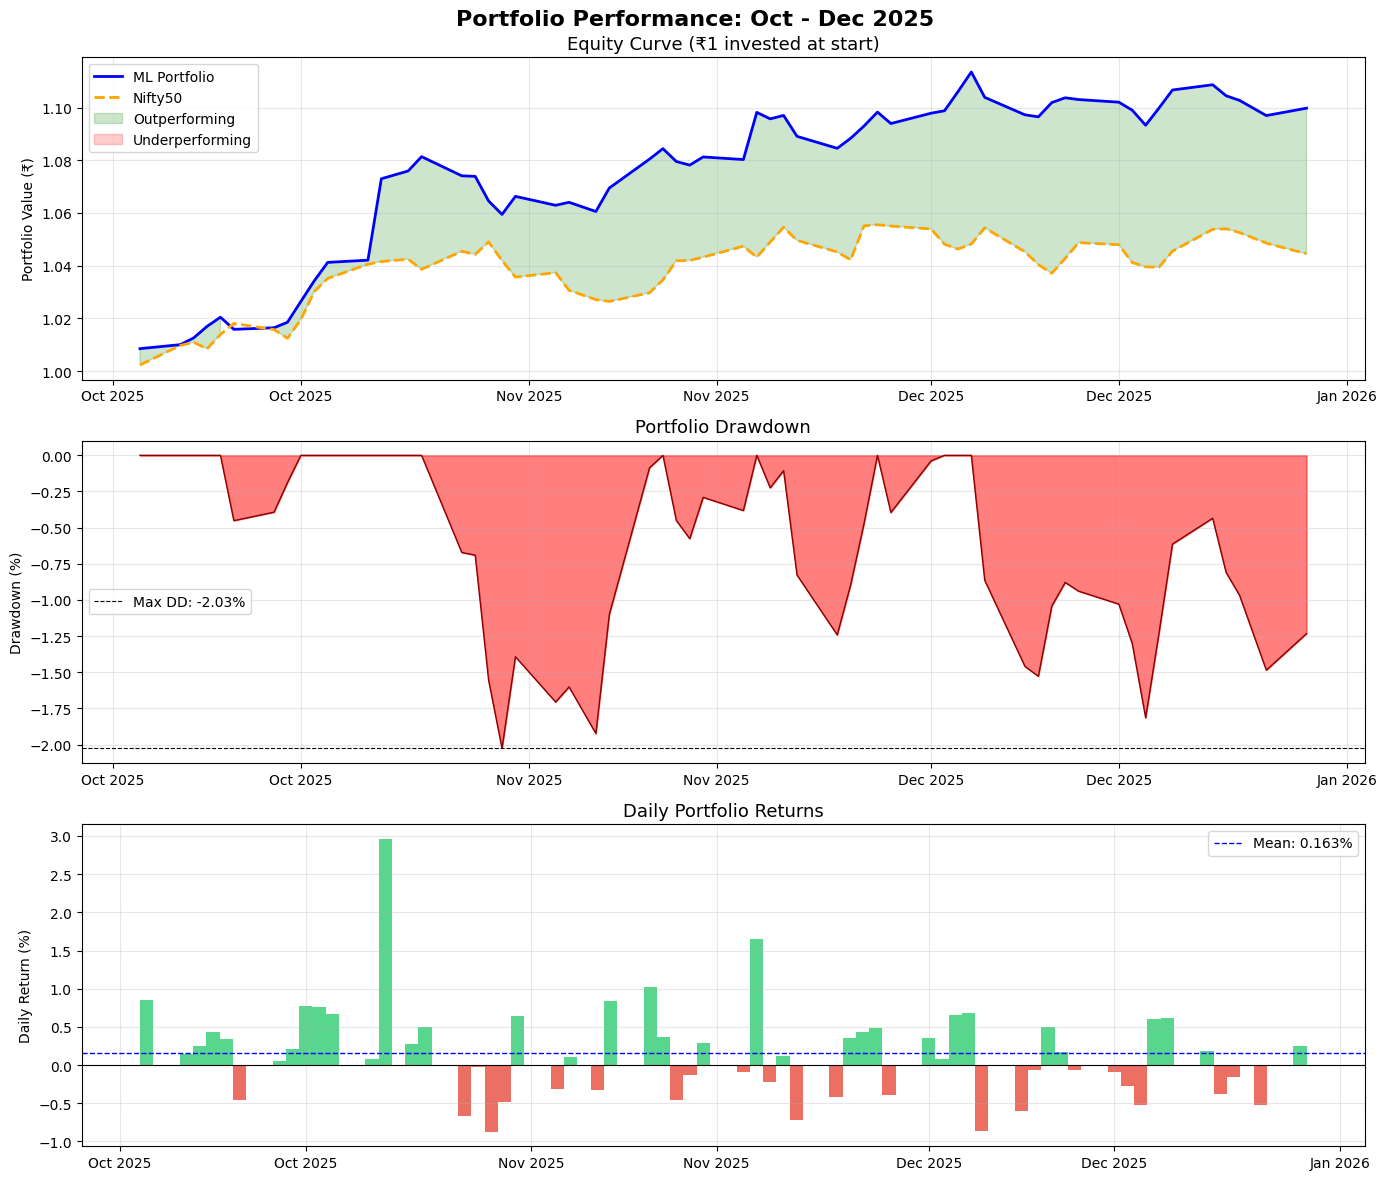

Equity curve saved!

=== Final Summary ===
Starting Value  : ₹1.0000
Ending Value    : ₹1.0998
Total Return    : 9.98%
Nifty Return    : 4.45%
Alpha vs Nifty  : 5.52%


In [110]:
print("\n=== Benchmark Comparison ===")
print(f"{'Metric':<25} {'Portfolio':>12} {'Nifty50':>12}")
print("-" * 50)
print(f"{'Annualized Return':<25} {ann_return:>11.2f}% {nifty_ann_ret:>11.2f}%")
print(f"{'Sharpe Ratio':<25} {sharpe:>12.4f} {nifty_sharpe:>12.4f}")
print(f"{'Max Drawdown':<25} {mdd*100:>11.2f}% {nifty_mdd*100:>11.2f}%")
print(f"{'Hit Ratio':<25} {hit_ratio:>11.2f}% {nifty_hit:>11.2f}%")

# ── 7f. Equity Curve ─────────────────────────────────────────────────
port_cum_aligned  = (1 + port_aligned).cumprod()
nifty_cum_aligned = (1 + nifty_aligned).cumprod()
drawdown_aligned  = (port_cum_aligned -
                     port_cum_aligned.cummax()) / port_cum_aligned.cummax()

fig, axes = plt.subplots(3, 1, figsize=(14, 12))
fig.suptitle("Portfolio Performance: Oct - Dec 2025",
             fontsize=16, fontweight="bold")

# Plot 1: Equity Curve
axes[0].plot(port_cum_aligned.index, port_cum_aligned.values,
             color="blue", linewidth=2, label="ML Portfolio")
axes[0].plot(nifty_cum_aligned.index, nifty_cum_aligned.values,
             color="orange", linewidth=2, linestyle="--", label="Nifty50")
axes[0].fill_between(port_cum_aligned.index,
                     port_cum_aligned.values,
                     nifty_cum_aligned.values,
                     where=port_cum_aligned.values >= nifty_cum_aligned.values,
                     alpha=0.2, color="green", label="Outperforming")
axes[0].fill_between(port_cum_aligned.index,
                     port_cum_aligned.values,
                     nifty_cum_aligned.values,
                     where=port_cum_aligned.values < nifty_cum_aligned.values,
                     alpha=0.2, color="red", label="Underperforming")
axes[0].set_title("Equity Curve (₹1 invested at start)", fontsize=13)
axes[0].set_ylabel("Portfolio Value (₹)")
axes[0].legend(loc="upper left")
axes[0].grid(True, alpha=0.3)
axes[0].xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))

# Plot 2: Drawdown
axes[1].fill_between(drawdown_aligned.index,
                     drawdown_aligned.values * 100,
                     0, color="red", alpha=0.5)
axes[1].plot(drawdown_aligned.index,
             drawdown_aligned.values * 100,
             color="darkred", linewidth=1)
axes[1].axhline(y=mdd * 100, color="black",
                linestyle="--", linewidth=0.8,
                label=f"Max DD: {mdd*100:.2f}%")
axes[1].set_title("Portfolio Drawdown", fontsize=13)
axes[1].set_ylabel("Drawdown (%)")
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))

# Plot 3: Daily Returns
colors_bar = ["#2ecc71" if r > 0 else "#e74c3c"
              for r in port_aligned.values]
axes[2].bar(port_aligned.index, port_aligned.values * 100,
            color=colors_bar, alpha=0.8, width=1)
axes[2].axhline(y=0, color="black", linewidth=0.8)
axes[2].axhline(y=port_aligned.mean() * 100,
                color="blue", linestyle="--", linewidth=1,
                label=f"Mean: {port_aligned.mean()*100:.3f}%")
axes[2].set_title("Daily Portfolio Returns", fontsize=13)
axes[2].set_ylabel("Daily Return (%)")
axes[2].legend()
axes[2].grid(True, alpha=0.3)
axes[2].xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))

plt.tight_layout()
plt.savefig("equity_curve.png", dpi=150, bbox_inches="tight")
plt.show()
print("Equity curve saved!")

# ── Final Summary ───────────────────────────────────────────────────────────
print(f"\n=== Final Summary ===")
print(f"Starting Value  : ₹1.0000")
print(f"Ending Value    : ₹{port_cum_aligned.iloc[-1]:.4f}")
print(f"Total Return    : {(port_cum_aligned.iloc[-1]-1)*100:.2f}%")
print(f"Nifty Return    : {(nifty_cum_aligned.iloc[-1]-1)*100:.2f}%")
print(f"Alpha vs Nifty  : {((port_cum_aligned.iloc[-1]-nifty_cum_aligned.iloc[-1])*100):.2f}%")

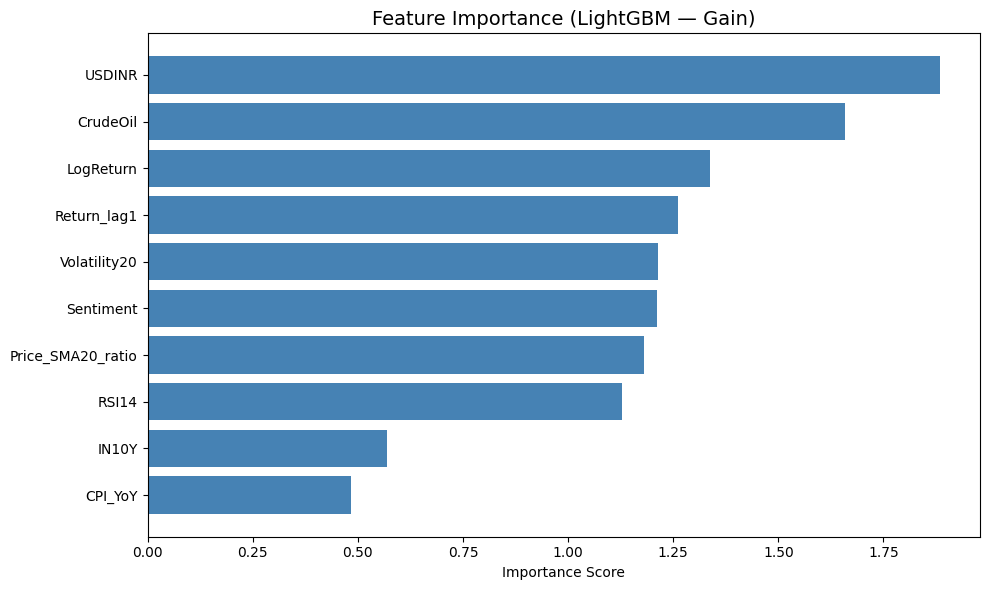

✅ Saved as feature_importance.png


In [105]:
# ── Feature Importance ────────────────────────────────────────────────
importance = final_model.feature_importance(importance_type="gain")
importance_df = pd.DataFrame({
    "Feature"   : selected_features,
    "Importance": importance
}).sort_values("Importance", ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="steelblue")
plt.title("Feature Importance (LightGBM — Gain)", fontsize=14)
plt.xlabel("Importance Score")
plt.tight_layout()
plt.savefig("feature_importance.png", dpi=150, bbox_inches="tight")
plt.show()
print("✅ Saved as feature_importance.png")